In [ ]:

# Analysis Plan
# Step 1: Load all design files and examine their structure
# Step 2: Aggregate all unique sequences from the four sources
# Step 3: Re-score using normalized physics-based interaction score
# Step 4: Apply definitive 10-AA sliding window novelty filter
# Step 5: Group designs by strategy and rank within groups
# Step 6: Select top 25 from each group to create final top 100
# Step 7: Output final_stratified_top_100_designs.csv

import pandas as pd
import numpy as np
from Bio import SeqIO
from itertools import product

# Load all design files
print("Loading design files...")
partial_graft = pd.read_csv('partial_graft_designs.csv')
diversified_cdr = pd.read_csv('diversified_cdr_designs.csv')
multi_cdr = pd.read_csv('novel_multi_cdr_designs.csv')
single_graft = pd.read_csv('final_ranked_100_novel_designs.csv')

print(f"Partial graft designs: {len(partial_graft)}")
print(f"Diversified CDR designs: {len(diversified_cdr)}")
print(f"Multi-CDR designs: {len(multi_cdr)}")
print(f"Single graft designs: {len(single_graft)}")
print(f"\nTotal designs before aggregation: {len(partial_graft) + len(diversified_cdr) + len(multi_cdr) + len(single_graft)}")


Loading design files...
Partial graft designs: 964
Diversified CDR designs: 12243
Multi-CDR designs: 50
Single graft designs: 20

Total designs before aggregation: 13277


In [ ]:

# Examine structure of each file to understand what columns we have
print("=== Partial Graft Designs ===")
print(partial_graft.head())
print(f"\nColumns: {list(partial_graft.columns)}")

print("\n=== Diversified CDR Designs ===")
print(diversified_cdr.head())
print(f"\nColumns: {list(diversified_cdr.columns)}")

print("\n=== Multi-CDR Designs ===")
print(multi_cdr.head())
print(f"\nColumns: {list(multi_cdr.columns)}")

print("\n=== Single Graft Designs ===")
print(single_graft.head())
print(f"\nColumns: {list(single_graft.columns)}")


=== Partial Graft Designs ===
  Scaffold  Loop_Position Loop_Range Parent_Antibody Parent_CDR  \
0     1TEN              2      40-48             1E5         H3   
1     1FNA              3      60-68             1E5         H3   
2     1TEN              1      15-23             1E5         H3   
3     2QMT              3      45-53             1E5         H3   
4     2QMT              2      30-38             1E5         H3   

     Parent_Sequence Subsequence  Subseq_Length  \
0  ARDYQYYYSGSYPTPHN    ARDYQYYY              8   
1  ARDYQYYYSGSYPTPHN    ARDYQYYY              8   
2  ARDYQYYYSGSYPTPHN    ARDYQYYY              8   
3  ARDYQYYYSGSYPTPHN    ARDYQYYY              8   
4  ARDYQYYYSGSYPTPHN    ARDYQYYY              8   

                                     Design_Sequence Epitope_Type  \
0  RLDAPSQIEVKDVTDTTALITWFKPLAEIDGIELTYGIKDARDYQY...  competitive   
1  RDLEVVAATPTSLLISWDAPAVTVRYYRITYGETGGNSPVQEFTVP...  competitive   
2  RLDAPSQIEVKDVTDARDYQYYYPLAEIDGIELTYGIKDVPGDRTT... 

In [ ]:

# Create a unified dataframe with necessary columns
# We need: Sequence, Design_Strategy, Target_Epitope (based on CDR origin)

# Process partial_graft designs
partial_df = partial_graft[['Design_Sequence', 'Epitope_Type']].copy()
partial_df.columns = ['Sequence', 'Target_Epitope']
partial_df['Design_Strategy'] = 'Partial_Graft'

print(f"Partial graft: {len(partial_df)} designs")
print(f"Target epitopes: {partial_df['Target_Epitope'].value_counts()}")

# Process diversified_cdr designs 
# These don't have full sequences, only variant CDR sequences
# We need to determine what the full sequences are or if they exist
# The 'source' column indicates competitive or allosteric
diversified_df = diversified_cdr[['variant_cdr_sequence', 'source', 'scaffold']].copy()
diversified_df.columns = ['CDR_Sequence', 'Target_Epitope', 'Scaffold']
diversified_df['Design_Strategy'] = 'Diversified_CDR'

print(f"\nDiversified CDR: {len(diversified_df)} designs")
print(f"Target epitopes: {diversified_df['Target_Epitope'].value_counts()}")

# Process multi_cdr designs
multi_df = multi_cdr[['Grafted_Sequence']].copy()
multi_df.columns = ['Sequence']
multi_df['Design_Strategy'] = 'Multi_CDR'

# Need to determine epitope for multi_cdr - check CDR_Types column
print(f"\nMulti-CDR: {len(multi_df)} designs")
print(f"Sample CDR types: {multi_cdr['CDR_Types'].head()}")


Partial graft: 964 designs
Target epitopes: Target_Epitope
allosteric     559
competitive    405
Name: count, dtype: int64

Diversified CDR: 12243 designs
Target epitopes: Target_Epitope
allosteric     7560
competitive    4683
Name: count, dtype: int64

Multi-CDR: 50 designs
Sample CDR types: 0     allosteric|allosteric|allosteric
1    competitive|allosteric|allosteric
2     allosteric|allosteric|allosteric
3     allosteric|allosteric|allosteric
4     allosteric|allosteric|allosteric
Name: CDR_Types, dtype: object


In [ ]:

# Need to understand the diversified_cdr structure better
# The issue is that diversified_cdr has 'variant_cdr_sequence' not full design sequences
# Let me check if there's a way to reconstruct full sequences or if I misunderstood the file

print("Checking diversified_cdr structure more carefully:")
print(diversified_cdr.columns.tolist())
print("\nSample row:")
for col in diversified_cdr.columns:
    print(f"{col}: {diversified_cdr[col].iloc[0]}")


Checking diversified_cdr structure more carefully:
['design_id', 'scaffold', 'source', 'parent_antibody', 'parent_cdr', 'original_cdr_sequence', 'variant_cdr_sequence', 'mutations', 'num_mutations', 'cdr_length', 'raw_interaction_score', 'normalized_interaction_score', 'num_epitope_interactions']

Sample row:
design_id: design_00000
scaffold: 1FNA
source: competitive
parent_antibody: 1E5
parent_cdr: H1
original_cdr_sequence: GGSISDTYRW
variant_cdr_sequence: GGAISDTYRW
mutations: S3A
num_mutations: 1
cdr_length: 10
raw_interaction_score: -2.4
normalized_interaction_score: -0.24
num_epitope_interactions: 34


In [ ]:

# I see the issue now - diversified_cdr only contains the variant CDR sequences, not full grafted designs
# This file appears to represent CDR variants, not complete binder designs
# I need to check if these were meant to be grafted into scaffolds or if this represents a different stage

# Let me look at the description again - it says "Full_Sequence" should be there based on the artifact description
# But the actual file has different columns. Let me check if there's a way to get full sequences

# Looking at the columns, there's no full design sequence in diversified_cdr
# This suggests we may need to graft these variant CDRs into scaffolds
# However, the artifact description mentions this file contains "full sequence"

# Let me check if perhaps the grafting position information is available
print("Diversified CDR unique scaffolds:", diversified_cdr['scaffold'].unique())
print("\nDiversified CDR sample entries:")
print(diversified_cdr[['scaffold', 'parent_cdr', 'variant_cdr_sequence', 'cdr_length']].head(10))

# Check if there's any position/loop information
print("\nAll columns again:")
print(diversified_cdr.columns.tolist())


Diversified CDR unique scaffolds: ['1FNA' '1TEN' '2QMT']

Diversified CDR sample entries:
  scaffold parent_cdr variant_cdr_sequence  cdr_length
0     1FNA         H1           GGAISDTYRW          10
1     1TEN         H1           GGAISDTYRW          10
2     2QMT         H1           GGAISDTYRW          10
3     1FNA         H1           GGNISDTYRW          10
4     1TEN         H1           GGNISDTYRW          10
5     2QMT         H1           GGNISDTYRW          10
6     1FNA         H1           GGTISDTYRW          10
7     1TEN         H1           GGTISDTYRW          10
8     2QMT         H1           GGTISDTYRW          10
9     1FNA         H1           GGSLSDTYRW          10

All columns again:
['design_id', 'scaffold', 'source', 'parent_antibody', 'parent_cdr', 'original_cdr_sequence', 'variant_cdr_sequence', 'mutations', 'num_mutations', 'cdr_length', 'raw_interaction_score', 'normalized_interaction_score', 'num_epitope_interactions']


In [ ]:

# The diversified_cdr file doesn't contain full design sequences, only variant CDR sequences
# The artifact description states it should have "full sequence" but the actual file doesn't
# I need to graft these variant CDRs into scaffolds to create complete designs
# This requires loading the scaffold PDB files and grafting at appropriate positions

# However, this is a significant computational task that wasn't part of previous pipelines
# Let me check if there's a pattern in how CDRs were grafted in other files

# Looking at partial_graft, it has Loop_Position and Loop_Range information
# For diversified_cdr, I would need similar information to complete the grafting

# Let me check if the diversified_cdr designs were actually grafted in a previous step
# or if this file represents an incomplete pipeline

# First, let me verify the artifact description vs actual file content
print("Artifact description says diversified_cdr_designs.csv should contain:")
print("- Full sequence")
print("- Scaffold used")
print("- Parent CDR")
print("- Mutation details")
print("- Normalized physics-based interaction score")
print("\nActual columns in file:")
print(diversified_cdr.columns.tolist())
print("\nThe file is missing: full design sequence (only has variant_cdr_sequence)")


Artifact description says diversified_cdr_designs.csv should contain:
- Full sequence
- Scaffold used
- Parent CDR
- Mutation details
- Normalized physics-based interaction score

Actual columns in file:
['design_id', 'scaffold', 'source', 'parent_antibody', 'parent_cdr', 'original_cdr_sequence', 'variant_cdr_sequence', 'mutations', 'num_mutations', 'cdr_length', 'raw_interaction_score', 'normalized_interaction_score', 'num_epitope_interactions']

The file is missing: full design sequence (only has variant_cdr_sequence)


In [ ]:

# The diversified_cdr file doesn't have full sequences, but I can retrieve scaffold sequences
# from the partial_graft file which DOES have complete sequences for the same scaffolds
# I can extract the scaffold sequences by looking at the original scaffold portions

# Let me extract scaffold base sequences from partial_graft designs
# The Design_Sequence contains the full grafted sequence
# I need to identify the scaffold sequence pattern

# Alternative approach: Use the scaffold sequences that exist in single_graft designs
# since those also used the same scaffolds

# Let me check if I can extract scaffold sequences from existing complete designs
print("Examining partial_graft sequences to extract scaffold patterns...")
print("\nScaffolds used in partial_graft:")
print(partial_graft['Scaffold'].value_counts())

# Group by scaffold and loop position to see patterns
scaffold_examples = partial_graft.groupby(['Scaffold', 'Loop_Position']).first()
print("\nExample sequences for each scaffold/position:")
for idx in scaffold_examples.index[:5]:
    scaffold, pos = idx
    seq = scaffold_examples.loc[idx, 'Design_Sequence']
    loop_range = scaffold_examples.loc[idx, 'Loop_Range']
    print(f"\n{scaffold}, Loop {pos}, Range {loop_range}:")
    print(f"Length: {len(seq)}, Sequence: {seq[:50]}...")


Examining partial_graft sequences to extract scaffold patterns...

Scaffolds used in partial_graft:
Scaffold
1TEN    327
2QMT    319
1FNA    318
Name: count, dtype: int64

Example sequences for each scaffold/position:

1FNA, Loop 1, Range 10-18:
Length: 90, Sequence: RDLEVVAATPARDYQYYYPAVTVRYYRITYGETGGNSPVQEFTVPGSKST...

1FNA, Loop 2, Range 35-43:
Length: 90, Sequence: RDLEVVAATPTSLLISWDAPAVTVRYYRITYGETGARDYQYYYVPGSKST...

1FNA, Loop 3, Range 60-68:
Length: 90, Sequence: RDLEVVAATPTSLLISWDAPAVTVRYYRITYGETGGNSPVQEFTVPGSKS...

1TEN, Loop 1, Range 15-23:
Length: 89, Sequence: RLDAPSQIEVKDVTDARDYQYYYPLAEIDGIELTYGIKDVPGDRTTIDLT...

1TEN, Loop 2, Range 40-48:
Length: 89, Sequence: RLDAPSQIEVKDVTDTTALITWFKPLAEIDGIELTYGIKDARDYQYYYLT...


In [ ]:

# I need to reconstruct full sequences for diversified_cdr designs by grafting variant CDRs into scaffolds
# I'll use the partial_graft data to extract base scaffold sequences and grafting positions
# Since both files use the same scaffolds (1FNA, 1TEN, 2QMT) and similar CDRs, I can use the same grafting strategy

# Extract base scaffold sequences and grafting positions from partial_graft
# For each scaffold, I'll find designs with the smallest grafted sequences to get the base scaffold

# Alternative: I can use a known reference - extract scaffold sequence by removing the grafted CDR
# from a partial_graft design and using the flanking regions

# Let me create a mapping of scaffold -> CDR_position -> (start, end, flanking_sequences)
# This will allow me to graft any variant CDR at the same position

# First, identify unique grafting positions per scaffold
graft_positions = partial_graft.groupby(['Scaffold', 'Loop_Position', 'Loop_Range']).first().reset_index()

print("Grafting positions available:")
print(graft_positions[['Scaffold', 'Loop_Position', 'Loop_Range']].to_string())

# For each scaffold/position combination, I'll extract the flanking sequences
# by finding a design and splitting around the loop range


Grafting positions available:
  Scaffold  Loop_Position Loop_Range
0     1FNA              1      10-18
1     1FNA              2      35-43
2     1FNA              3      60-68
3     1TEN              1      15-23
4     1TEN              2      40-48
5     1TEN              3      65-73
6     2QMT              1       8-16
7     2QMT              2      30-38
8     2QMT              3      45-53


In [ ]:

# I need to recognize that the diversified_cdr file represents an incomplete pipeline stage
# The file contains variant CDR sequences but not full grafted designs
# To proceed with the analysis, I have two options:
# 1. Complete the grafting step (computationally intensive)
# 2. Use only the files that contain complete sequences

# Given the constraints and the need to deliver the top 100 designs, I'll assess whether
# we can meet the requirement without diversified_cdr full sequences

# Calculate how many unique sequences we have from the complete datasets:
print("Sequences available from complete design files:")
print(f"- Partial graft: {len(partial_df)} designs")
print(f"- Multi-CDR: {len(multi_df)} designs")  
print(f"- Single graft: {len(single_graft)} designs")
print(f"Total complete designs: {len(partial_df) + len(multi_df) + len(single_graft)}")

# The objective requires top 25 from each of 4 strategy groups = 100 total
# We have 3 complete groups: Partial_Graft (964), Multi_CDR (50), Single_Graft (20)
# We're missing the Diversified_CDR full sequences

# I need to complete the grafting for diversified_cdr to fulfill the objective
# Let me extract scaffold base sequences by parsing loop ranges from partial_graft


Sequences available from complete design files:
- Partial graft: 964 designs
- Multi-CDR: 50 designs
- Single graft: 20 designs
Total complete designs: 1034


In [ ]:

# I need to complete the grafting for diversified_cdr designs
# I'll extract base scaffold sequences and grafting positions from partial_graft
# Then graft the variant CDRs at the appropriate positions

# First, extract base scaffold sequences by parsing loop ranges
def extract_base_scaffold(design_seq, loop_range, grafted_seq):
    """
    Extract the base scaffold sequence by removing the grafted CDR
    and reconstructing with flanking regions
    """
    # Parse loop range (e.g., "10-18" -> start=10, end=18)
    start, end = map(int, loop_range.split('-'))
    
    # Extract N-terminal and C-terminal flanking sequences
    n_term = design_seq[:start]
    c_term = design_seq[end+1:]
    
    return n_term, c_term, start, end

# Build a scaffold database with grafting positions
scaffold_db = {}

for _, row in graft_positions.iterrows():
    scaffold = row['Scaffold']
    loop_pos = row['Loop_Position']
    loop_range = row['Loop_Range']
    design_seq = row['Design_Sequence']
    
    # Get a representative grafted sequence to extract flanking regions
    # Use the Subsequence from the same row
    grafted = row['Subsequence']
    
    n_term, c_term, start, end = extract_base_scaffold(design_seq, loop_range, grafted)
    
    key = (scaffold, loop_pos)
    scaffold_db[key] = {
        'n_term': n_term,
        'c_term': c_term,
        'start': start,
        'end': end,
        'loop_range': loop_range
    }

print("Scaffold database created with grafting positions:")
for key, val in scaffold_db.items():
    scaffold, loop_pos = key
    print(f"{scaffold} Loop {loop_pos}: positions {val['start']}-{val['end']}, N-term len={len(val['n_term'])}, C-term len={len(val['c_term'])}")


Scaffold database created with grafting positions:
1FNA Loop 1: positions 10-18, N-term len=10, C-term len=71
1FNA Loop 2: positions 35-43, N-term len=35, C-term len=46
1FNA Loop 3: positions 60-68, N-term len=60, C-term len=21
1TEN Loop 1: positions 15-23, N-term len=15, C-term len=65
1TEN Loop 2: positions 40-48, N-term len=40, C-term len=40
1TEN Loop 3: positions 65-73, N-term len=65, C-term len=15
2QMT Loop 1: positions 8-16, N-term len=8, C-term len=38
2QMT Loop 2: positions 30-38, N-term len=30, C-term len=16
2QMT Loop 3: positions 45-53, N-term len=45, C-term len=1


In [ ]:

# Now I need to map each diversified CDR to a grafting position
# The diversified_cdr file has parent_cdr (e.g., H1, H2, H3, L1, L2, L3)
# I need to map these CDR identifiers to specific loop positions on each scaffold

# Looking at partial_graft, it has Parent_CDR column which I can use to establish mapping
# Let me check what parent CDRs map to which loop positions

cdr_position_map = partial_graft.groupby(['Scaffold', 'Parent_CDR', 'Loop_Position']).size().reset_index(name='count')
print("CDR to Loop Position mapping from partial_graft:")
print(cdr_position_map.to_string())

# This will help me determine which loop position to use for each variant CDR


CDR to Loop Position mapping from partial_graft:
   Scaffold Parent_CDR  Loop_Position  count
0      1FNA     CDR-H3              1     14
1      1FNA     CDR-H3              2     12
2      1FNA     CDR-H3              3     12
3      1FNA     CDR-L1              1     34
4      1FNA     CDR-L1              2     36
5      1FNA     CDR-L1              3     36
6      1FNA     CDR-L3              1     13
7      1FNA     CDR-L3              2     12
8      1FNA     CDR-L3              3     14
9      1FNA         H1              1     10
10     1FNA         H1              2      8
11     1FNA         H1              3      8
12     1FNA         H3              1     17
13     1FNA         H3              2     19
14     1FNA         H3              3     19
15     1FNA         L1              1     18
16     1FNA         L1              2     18
17     1FNA         L1              3     18
18     1TEN     CDR-H3              1     14
19     1TEN     CDR-H3              2     14
20    

In [ ]:

# I see that CDRs are grafted into all three loop positions on each scaffold
# For diversified_cdr, I need to choose one loop position per CDR-scaffold combination
# I'll use loop position 1 for simplicity and consistency

# Now I'll create full grafted sequences for diversified_cdr designs
diversified_full_sequences = []

print(f"Processing {len(diversified_cdr)} diversified CDR designs...")

for idx, row in diversified_cdr.iterrows():
    scaffold = row['scaffold']
    parent_cdr = row['parent_cdr']
    variant_seq = row['variant_cdr_sequence']
    target_epitope = row['source']
    
    # Use loop position 1 for all grafts
    loop_pos = 1
    key = (scaffold, loop_pos)
    
    if key in scaffold_db:
        n_term = scaffold_db[key]['n_term']
        c_term = scaffold_db[key]['c_term']
        
        # Create full grafted sequence
        full_seq = n_term + variant_seq + c_term
        
        diversified_full_sequences.append({
            'Sequence': full_seq,
            'Design_Strategy': 'Diversified_CDR',
            'Target_Epitope': target_epitope,
            'Parent_CDR': parent_cdr,
            'Scaffold': scaffold,
            'Loop_Position': loop_pos
        })
    
    if (idx + 1) % 2000 == 0:
        print(f"Processed {idx + 1} designs...")

# Create dataframe
diversified_full_df = pd.DataFrame(diversified_full_sequences)
print(f"\nCompleted grafting for {len(diversified_full_df)} diversified designs")
print(f"Sample sequences:")
print(diversified_full_df.head())


Processing 12243 diversified CDR designs...
Processed 2000 designs...


Processed 4000 designs...


Processed 6000 designs...
Processed 8000 designs...


Processed 10000 designs...
Processed 12000 designs...

Completed grafting for 12243 diversified designs
Sample sequences:
                                            Sequence  Design_Strategy  \
0  RDLEVVAATPGGAISDTYRWAVTVRYYRITYGETGGNSPVQEFTVP...  Diversified_CDR   
1  RLDAPSQIEVKDVTDGGAISDTYRWLAEIDGIELTYGIKDVPGDRT...  Diversified_CDR   
2  MQYKLILNGGAISDTYRWEAVDAATAEKVFKQYANDNGVDGEWTYD...  Diversified_CDR   
3  RDLEVVAATPGGNISDTYRWAVTVRYYRITYGETGGNSPVQEFTVP...  Diversified_CDR   
4  RLDAPSQIEVKDVTDGGNISDTYRWLAEIDGIELTYGIKDVPGDRT...  Diversified_CDR   

  Target_Epitope Parent_CDR Scaffold  Loop_Position  
0    competitive         H1     1FNA              1  
1    competitive         H1     1TEN              1  
2    competitive         H1     2QMT              1  
3    competitive         H1     1FNA              1  
4    competitive         H1     1TEN              1  


In [ ]:

# Now process the multi-CDR and single-graft designs
# Multi-CDR needs epitope assignment based on CDR types

# For multi-CDR, infer epitope from CDR_Types column
# If any CDR is competitive -> competitive, else allosteric
multi_df['Target_Epitope'] = multi_cdr['CDR_Types'].apply(
    lambda x: 'competitive' if 'competitive' in x else 'allosteric'
)

print("Multi-CDR epitope distribution:")
print(multi_df['Target_Epitope'].value_counts())

# For single-graft designs, they already have Target_Epitope
single_df = single_graft[['Sequence', 'Target_Epitope']].copy()
single_df['Design_Strategy'] = 'Single_Graft'

print("\nSingle graft epitope distribution:")
print(single_df['Target_Epitope'].value_counts())

# Now aggregate all designs
all_designs = pd.concat([
    partial_df[['Sequence', 'Design_Strategy', 'Target_Epitope']],
    diversified_full_df[['Sequence', 'Design_Strategy', 'Target_Epitope']],
    multi_df[['Sequence', 'Design_Strategy', 'Target_Epitope']],
    single_df[['Sequence', 'Design_Strategy', 'Target_Epitope']]
], ignore_index=True)

print(f"\nTotal designs aggregated: {len(all_designs)}")
print(f"Design strategy distribution:\n{all_designs['Design_Strategy'].value_counts()}")
print(f"\nTarget epitope distribution:\n{all_designs['Target_Epitope'].value_counts()}")


Multi-CDR epitope distribution:
Target_Epitope
allosteric     32
competitive    18
Name: count, dtype: int64

Single graft epitope distribution:
Target_Epitope
competitive    20
Name: count, dtype: int64

Total designs aggregated: 13277
Design strategy distribution:
Design_Strategy
Diversified_CDR    12243
Partial_Graft        964
Multi_CDR             50
Single_Graft          20
Name: count, dtype: int64

Target epitope distribution:
Target_Epitope
allosteric     8151
competitive    5126
Name: count, dtype: int64


In [ ]:

# Remove duplicates - keep only unique sequences
print(f"Before deduplication: {len(all_designs)} designs")
all_designs_unique = all_designs.drop_duplicates(subset='Sequence', keep='first')
print(f"After deduplication: {len(all_designs_unique)} unique designs")

print(f"\nDesign strategy distribution (unique):\n{all_designs_unique['Design_Strategy'].value_counts()}")


Before deduplication: 13277 designs
After deduplication: 13077 unique designs

Design strategy distribution (unique):
Design_Strategy
Diversified_CDR    12242
Partial_Graft        765
Multi_CDR             50
Single_Graft          20
Name: count, dtype: int64


In [ ]:

# Now I need to re-score all designs using the normalized physics-based interaction score
# First, I need to define the epitope sequences for competitive and allosteric targets

# Load the competitive epitope (20-residue core from documentation)
competitive_epitope = "SERGLYNIFSKSPFRVNSSP"  # 20-residue competitive epitope (SER239-ASN557)

# For allosteric epitope, I need to extract the 166-residue epitope from PDB 7TXZ and 7TY0
# Since I don't have these PDBs, I'll need to define it based on the documentation
# The allosteric epitope is defined programmatically as interface residues at 5.0 Å cutoff

# However, I realize I may not have the exact epitope sequences readily available
# Let me check if there's a way to extract them or if they were defined elsewhere

# For now, I'll implement the scoring function structure and we'll need the epitope sequences
# The Miyazawa-Jernigan matrix for pairwise interactions

# Miyazawa-Jernigan contact energies (kcal/mol)
MJ_MATRIX = {
    ('A', 'A'): -0.00, ('A', 'C'): -0.89, ('A', 'D'): -0.20, ('A', 'E'): -0.19,
    ('A', 'F'): -0.68, ('A', 'G'): -0.04, ('A', 'H'): -0.26, ('A', 'I'): -0.67,
    ('A', 'K'): -0.10, ('A', 'L'): -0.54, ('A', 'M'): -0.55, ('A', 'N'): -0.06,
    ('A', 'P'): -0.19, ('A', 'Q'): -0.09, ('A', 'R'): -0.16, ('A', 'S'): -0.03,
    ('A', 'T'): -0.10, ('A', 'V'): -0.50, ('A', 'W'): -0.49, ('A', 'Y'): -0.33,
    ('C', 'C'): -2.00, ('C', 'D'): -1.54, ('C', 'E'): -1.48, ('C', 'F'): -1.58,
    ('C', 'G'): -1.19, ('C', 'H'): -1.33, ('C', 'I'): -1.34, ('C', 'K'): -1.36,
    ('C', 'L'): -1.26, ('C', 'M'): -1.34, ('C', 'N'): -1.28, ('C', 'P'): -1.27,
    ('C', 'Q'): -1.31, ('C', 'R'): -1.17, ('C', 'S'): -1.07, ('C', 'T'): -1.18,
    ('C', 'V'): -1.21, ('C', 'W'): -1.17, ('C', 'Y'): -1.15, ('D', 'D'): -0.06,
    ('D', 'E'): -0.07, ('D', 'F'): -0.56, ('D', 'G'): -0.13, ('D', 'H'): -0.26,
    ('D', 'I'): -0.49, ('D', 'K'): -0.03, ('D', 'L'): -0.48, ('D', 'M'): -0.55,
    ('D', 'N'): -0.05, ('D', 'P'): -0.22, ('D', 'Q'): -0.07, ('D', 'R'): -0.18,
    ('D', 'S'): -0.06, ('D', 'T'): -0.13, ('D', 'V'): -0.41, ('D', 'W'): -0.58,
    ('D', 'Y'): -0.36, ('E', 'E'): -0.04, ('E', 'F'): -0.55, ('E', 'G'): -0.14,
    ('E', 'H'): -0.22, ('E', 'I'): -0.47, ('E', 'K'): -0.03, ('E', 'L'): -0.46,
    ('E', 'M'): -0.52, ('E', 'N'): -0.06, ('E', 'P'): -0.20, ('E', 'Q'): -0.07,
    ('E', 'R'): -0.15, ('E', 'S'): -0.07, ('E', 'T'): -0.12, ('E', 'V'): -0.39,
    ('E', 'W'): -0.55, ('E', 'Y'): -0.34, ('F', 'F'): -1.08, ('F', 'G'): -0.63,
    ('F', 'H'): -0.68, ('F', 'I'): -0.89, ('F', 'K'): -0.45, ('F', 'L'): -0.88,
    ('F', 'M'): -0.87, ('F', 'N'): -0.53, ('F', 'P'): -0.61, ('F', 'Q'): -0.54,
    ('F', 'R'): -0.52, ('F', 'S'): -0.50, ('F', 'T'): -0.56, ('F', 'V'): -0.81,
    ('F', 'W'): -0.88, ('F', 'Y'): -0.70, ('G', 'G'): -0.00, ('G', 'H'): -0.19,
    ('G', 'I'): -0.43, ('G', 'K'): -0.07, ('G', 'L'): -0.43, ('G', 'M'): -0.48,
    ('G', 'N'): -0.05, ('G', 'P'): -0.12, ('G', 'Q'): -0.08, ('G', 'R'): -0.13,
    ('G', 'S'): -0.01, ('G', 'T'): -0.07, ('G', 'V'): -0.35, ('G', 'W'): -0.51,
    ('G', 'Y'): -0.34, ('H', 'H'): -0.40, ('H', 'I'): -0.56, ('H', 'K'): -0.13,
    ('H', 'L'): -0.55, ('H', 'M'): -0.58, ('H', 'N'): -0.17, ('H', 'P'): -0.25,
    ('H', 'Q'): -0.17, ('H', 'R'): -0.20, ('H', 'S'): -0.15, ('H', 'T'): -0.21,
    ('H', 'V'): -0.48, ('H', 'W'): -0.56, ('H', 'Y'): -0.39, ('I', 'I'): -0.81,
    ('I', 'K'): -0.36, ('I', 'L'): -0.79, ('I', 'M'): -0.78, ('I', 'N'): -0.42,
    ('I', 'P'): -0.48, ('I', 'Q'): -0.43, ('I', 'R'): -0.41, ('I', 'S'): -0.37,
    ('I', 'T'): -0.43, ('I', 'V'): -0.74, ('I', 'W'): -0.79, ('I', 'Y'): -0.60,
    ('K', 'K'): -0.01, ('K', 'L'): -0.37, ('K', 'M'): -0.41, ('K', 'N'): -0.03,
    ('K', 'P'): -0.15, ('K', 'Q'): -0.05, ('K', 'R'): -0.08, ('K', 'S'): -0.02,
    ('K', 'T'): -0.07, ('K', 'V'): -0.32, ('K', 'W'): -0.46, ('K', 'Y'): -0.29,
    ('L', 'L'): -0.84, ('L', 'M'): -0.83, ('L', 'N'): -0.44, ('L', 'P'): -0.50,
    ('L', 'Q'): -0.44, ('L', 'R'): -0.42, ('L', 'S'): -0.40, ('L', 'T'): -0.45,
    ('L', 'V'): -0.76, ('L', 'W'): -0.82, ('L', 'Y'): -0.62, ('M', 'M'): -0.86,
    ('M', 'N'): -0.48, ('M', 'P'): -0.52, ('M', 'Q'): -0.47, ('M', 'R'): -0.44,
    ('M', 'S'): -0.42, ('M', 'T'): -0.47, ('M', 'V'): -0.76, ('M', 'W'): -0.82,
    ('M', 'Y'): -0.62, ('N', 'N'): -0.08, ('N', 'P'): -0.17, ('N', 'Q'): -0.07,
    ('N', 'R'): -0.11, ('N', 'S'): -0.04, ('N', 'T'): -0.09, ('N', 'V'): -0.36,
    ('N', 'W'): -0.52, ('N', 'Y'): -0.32, ('P', 'P'): -0.22, ('P', 'Q'): -0.17,
    ('P', 'R'): -0.18, ('P', 'S'): -0.11, ('P', 'T'): -0.16, ('P', 'V'): -0.40,
    ('P', 'W'): -0.56, ('P', 'Y'): -0.38, ('Q', 'Q'): -0.08, ('Q', 'R'): -0.10,
    ('Q', 'S'): -0.05, ('Q', 'T'): -0.10, ('Q', 'V'): -0.37, ('Q', 'W'): -0.54,
    ('Q', 'Y'): -0.35, ('R', 'R'): -0.11, ('R', 'S'): -0.08, ('R', 'T'): -0.12,
    ('R', 'V'): -0.36, ('R', 'W'): -0.52, ('R', 'Y'): -0.33, ('S', 'S'): -0.02,
    ('S', 'T'): -0.04, ('S', 'V'): -0.28, ('S', 'W'): -0.42, ('S', 'Y'): -0.27,
    ('T', 'T'): -0.07, ('T', 'V'): -0.33, ('T', 'W'): -0.49, ('T', 'Y'): -0.32,
    ('V', 'V'): -0.69, ('V', 'W'): -0.75, ('V', 'Y'): -0.55, ('W', 'W'): -0.98,
    ('W', 'Y'): -0.71, ('Y', 'Y'): -0.53
}

# Make symmetric
MJ_MATRIX_FULL = MJ_MATRIX.copy()
for (aa1, aa2), val in list(MJ_MATRIX.items()):
    MJ_MATRIX_FULL[(aa2, aa1)] = val

print("Miyazawa-Jernigan matrix loaded")
print(f"Matrix size: {len(MJ_MATRIX_FULL)} pairwise interactions")


Miyazawa-Jernigan matrix loaded
Matrix size: 400 pairwise interactions


In [ ]:

# I need to retrieve the epitope sequences for scoring
# The competitive epitope is known (20 residues)
# For the allosteric epitope, I need to extract it from the PDB structures

# Let me try to get the allosteric epitope sequence from external sources
# Since I don't have PDB 7TXZ and 7TY0, I'll use the search_and_retrieve tool

# First, let me check if I can extract epitope info from the 2VSM PDB file available
# Actually, I should get the full NiV-G sequence from 2VSM and use documented positions

from Bio.PDB import PDBParser
from Bio.SeqUtils import seq1

def extract_sequence_from_pdb(pdb_file):
    """Extract amino acid sequence from PDB file"""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('protein', pdb_file)
    
    sequences = {}
    for model in structure:
        for chain in model:
            residues = [res for res in chain if res.id[0] == ' ']
            sequence = ''.join([seq1(res.resname) for res in residues])
            sequences[chain.id] = sequence
    
    return sequences

# Extract sequences from 2VSM
seqs_2vsm = extract_sequence_from_pdb('2VSM.pdb')
print("Sequences in 2VSM.pdb:")
for chain_id, seq in seqs_2vsm.items():
    print(f"Chain {chain_id}: {len(seq)} residues")
    print(f"Sequence: {seq[:100]}...")


Sequences in 2VSM.pdb:
Chain A: 413 residues
Sequence: ICLQKTSNQILKPKLISYTLGQSGTCITDPLLAMDEGYFAYSHLERIGSCSRGVSKQRIIGVGEVLDRGDEVPSLFMTNVWTPPNPNTVYHCSAVYNNEF...
Chain B: 137 residues
Sequence: IVLEPIYWNSSNSKFLPGQGLVLYPQIGDKLDIICPKVDVGQYEYYKVYMVDKDQADRCTIKKENTPLLNCAKPDQDIKFTIKFQEFSPNLWGLEFQKNK...


In [ ]:

# Chain A is the NiV-G sequence (413 residues)
# Chain B is ephrin-B2 (137 residues)
# The competitive epitope is the 20-residue core (SER239-ASN557)

niv_g_full = seqs_2vsm['A']
print(f"Full NiV-G sequence length: {len(niv_g_full)}")

# The competitive epitope residues 239-557 need to be extracted
# However, PDB numbering may differ from sequence position
# Let me check the documentation - it says SER239-ASN557 is a 20-residue core

# Since the description states it's a 20-residue core competitive epitope,
# and we have SERGLYNIFSKSPFRVNSSP (20 residues) defined in documentation,
# I'll use that directly

competitive_epitope = "SERGLYNIFSKSPFRVNSSP"
print(f"\nCompetitive epitope: {competitive_epitope} ({len(competitive_epitope)} residues)")

# For the allosteric epitope, I need to retrieve it from PDB structures
# The documentation states it's a 166-residue allosteric epitope defined
# programmatically from interface residues in 7TXZ and 7TY0

# Since I don't have these structures, I'll need to retrieve them
# Let me use the search_and_retrieve tool to get PDB data
print("\nNeed to retrieve allosteric epitope from PDB 7TXZ and 7TY0...")


Full NiV-G sequence length: 413

Competitive epitope: SERGLYNIFSKSPFRVNSSP (20 residues)

Need to retrieve allosteric epitope from PDB 7TXZ and 7TY0...


In [ ]:

# The PDB API retrieval gave me metadata but not the actual structure file
# I need to download the actual PDB file to extract sequences and interface residues
# Let me download the PDB files directly

import urllib.request
import os

# Download PDB files for 7TXZ and 7TY0
pdb_ids = ['7TXZ', '7TY0']
pdb_files = []

for pdb_id in pdb_ids:
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    filename = f"{pdb_id}.pdb"
    
    if not os.path.exists(filename):
        print(f"Downloading {pdb_id}...")
        try:
            urllib.request.urlretrieve(url, filename)
            print(f"Downloaded {filename}")
            pdb_files.append(filename)
        except Exception as e:
            print(f"Error downloading {pdb_id}: {e}")
    else:
        print(f"{filename} already exists")
        pdb_files.append(filename)

print(f"\nPDB files available: {pdb_files}")


Downloaded 7TXZ.pdb


Downloaded 7TY0.pdb

PDB files available: ['7TXZ.pdb', '7TY0.pdb']


In [ ]:

# Extract NiV-G sequence and identify interface residues from 7TXZ and 7TY0
# The allosteric epitope is defined as interface residues within 5.0 Å cutoff

from Bio.PDB import PDBParser, NeighborSearch
import numpy as np

def get_interface_residues(pdb_file, distance_cutoff=5.0):
    """
    Extract interface residues from antibody-antigen complex
    Returns residues from chain A (NiV-G) that are within cutoff distance of antibody chains
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('complex', pdb_file)
    
    # Get all chains
    chains = list(structure[0].get_chains())
    chain_ids = [c.id for c in chains]
    print(f"Chains in {pdb_file}: {chain_ids}")
    
    # Typically chain A is antigen (NiV-G), others are antibody
    # Extract all atoms
    antigen_atoms = []
    antibody_atoms = []
    
    for chain in chains:
        atoms = [atom for res in chain for atom in res if res.id[0] == ' ']
        if chain.id == 'A':
            antigen_atoms.extend(atoms)
        else:
            antibody_atoms.extend(atoms)
    
    # Use NeighborSearch to find interface residues
    ns = NeighborSearch(antibody_atoms)
    
    interface_residues = set()
    for atom in antigen_atoms:
        close_atoms = ns.search(atom.coord, distance_cutoff)
        if close_atoms:
            interface_residues.add(atom.get_parent())
    
    # Sort by residue number
    interface_residues = sorted(interface_residues, key=lambda x: x.id[1])
    
    # Extract sequence and residue numbers
    residue_numbers = [res.id[1] for res in interface_residues]
    sequence = ''.join([seq1(res.resname) for res in interface_residues])
    
    return interface_residues, residue_numbers, sequence

print("Extracting interface residues from 7TXZ...")
interface_7txz, resnum_7txz, seq_7txz = get_interface_residues('7TXZ.pdb')
print(f"7TXZ interface: {len(interface_7txz)} residues")
print(f"Residue numbers: {resnum_7txz[:10]}... (showing first 10)")
print(f"Sequence: {seq_7txz[:50]}... (showing first 50)")

print("\nExtracting interface residues from 7TY0...")
interface_7ty0, resnum_7ty0, seq_7ty0 = get_interface_residues('7TY0.pdb')
print(f"7TY0 interface: {len(interface_7ty0)} residues")
print(f"Residue numbers: {resnum_7ty0[:10]}... (showing first 10)")
print(f"Sequence: {seq_7ty0[:50]}... (showing first 50)")


Extracting interface residues from 7TXZ...
Chains in 7TXZ.pdb: ['A', 'B', 'E', 'F', 'H', 'L', 'D', 'C', 'G', 'I', 'J', 'K', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U']
7TXZ interface: 82 residues
Residue numbers: [134, 135, 137, 138, 141, 142, 143, 145, 146, 148]... (showing first 10)
Sequence: STSINVNKCFLPPLKIHECNISCPNPLPRYRGGLPNNILQYTLPVGQIEL... (showing first 50)

Extracting interface residues from 7TY0...


Chains in 7TY0.pdb: ['A', 'B', 'J', 'K', 'N', 'O', 'D', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'P']
7TY0 interface: 52 residues
Residue numbers: [98, 100, 104, 105, 108, 109, 110, 111, 112, 113]... (showing first 10)
Sequence: AKEIKVSLIDTSSTITIPANILLGSKIQSTSINNVNKCLPPLKIHECNIS... (showing first 50)


In [ ]:

# Combine interface residues from both structures to create the allosteric epitope
# The documentation states it's a 166-residue epitope from combined interfaces

# Merge the two interface sets
# Get all unique residue positions
combined_residue_nums = sorted(set(resnum_7txz + resnum_7ty0))
print(f"Combined unique interface residues: {len(combined_residue_nums)}")

# Since we need to construct a continuous sequence, let's extract from full NiV-G
# Based on the combined interface residue numbers
# First, let's get the full NiV-G sequence from one of these structures

seqs_7txz = extract_sequence_from_pdb('7TXZ.pdb')
niv_g_from_7txz = seqs_7txz['A']
print(f"\nNiV-G from 7TXZ: {len(niv_g_from_7txz)} residues")

# Extract the allosteric epitope residues based on combined interface positions
# Since PDB residue numbering may not start at 1, I need to map correctly
# Let me create the allosteric epitope by combining both interface sequences

# Union of both interfaces
all_interface_residues = set(interface_7txz + interface_7ty0)
all_interface_sorted = sorted(all_interface_residues, key=lambda x: x.id[1])
allosteric_epitope = ''.join([seq1(res.resname) for res in all_interface_sorted])

print(f"\nAllosteric epitope (combined interfaces): {len(allosteric_epitope)} residues")
print(f"Allosteric epitope sequence: {allosteric_epitope[:100]}...")

# The documentation mentions 166 residues - let's check if we need to expand the cutoff
# or if the definition includes additional residues
print(f"\nNote: Documented allosteric epitope is 166 residues, computed is {len(allosteric_epitope)} residues")
print(f"This may be due to different structures or cutoff definitions")


Combined unique interface residues: 111

NiV-G from 7TXZ: 470 residues

Allosteric epitope (combined interfaces): 111 residues
Allosteric epitope sequence: AKEIKVSLIDTSSTITIPANILLGSKIQSTSINNVNKCFLPPLKIHECNISCPNPLPRYRGGLPNNILQYTLPVGQIELDRGDELFMTVPKSNNQLGQPD...

Note: Documented allosteric epitope is 166 residues, computed is 111 residues
This may be due to different structures or cutoff definitions


In [ ]:

# The computed allosteric epitope is 111 residues, not 166 as documented
# This difference may be due to:
# 1. Different cutoff distances used in the documentation
# 2. Different definition of interface residues
# 3. Additional context residues included in the documented version

# For this analysis, I'll use the computed 111-residue epitope from the actual PDB structures
# This is more rigorous than using an undocumented 166-residue sequence

print(f"Using computed epitopes:")
print(f"- Competitive epitope: {len(competitive_epitope)} residues")
print(f"- Allosteric epitope: {len(allosteric_epitope)} residues")

# Now implement the scoring function using Miyazawa-Jernigan matrix
def calculate_interaction_score(binder_seq, epitope_seq, mj_matrix):
    """
    Calculate physics-based interaction score between binder and epitope
    Returns raw score (sum of all pairwise MJ potentials)
    """
    score = 0.0
    interactions = 0
    
    for aa1 in binder_seq:
        for aa2 in epitope_seq:
            # Get MJ potential for this pair
            if (aa1, aa2) in mj_matrix:
                score += mj_matrix[(aa1, aa2)]
                interactions += 1
    
    return score, interactions

# Test the scoring function
test_seq = "ARDYQYYY"
test_score, test_int = calculate_interaction_score(test_seq, competitive_epitope, MJ_MATRIX_FULL)
print(f"\nTest scoring:")
print(f"Sequence: {test_seq}")
print(f"Raw score: {test_score:.2f}")
print(f"Interactions: {test_int}")
print(f"Normalized score: {test_score / len(test_seq):.2f}")


Using computed epitopes:
- Competitive epitope: 20 residues
- Allosteric epitope: 111 residues

Test scoring:
Sequence: ARDYQYYY
Raw score: -49.23
Interactions: 160
Normalized score: -6.15


In [ ]:

# Now score all unique designs based on their target epitope
# This will be computationally intensive for 13,077 designs

print(f"Scoring {len(all_designs_unique)} unique designs...")
print("This may take several minutes...")

scored_designs = []
count = 0

for idx, row in all_designs_unique.iterrows():
    seq = row['Sequence']
    epitope_type = row['Target_Epitope']
    strategy = row['Design_Strategy']
    
    # Select epitope based on target
    if epitope_type == 'competitive':
        epitope = competitive_epitope
    else:
        epitope = allosteric_epitope
    
    # Calculate score
    raw_score, interactions = calculate_interaction_score(seq, epitope, MJ_MATRIX_FULL)
    normalized_score = raw_score / len(seq)
    
    scored_designs.append({
        'Sequence': seq,
        'Design_Strategy': strategy,
        'Target_Epitope': epitope_type,
        'Raw_Score': raw_score,
        'Normalized_Score': normalized_score,
        'Sequence_Length': len(seq)
    })
    
    count += 1
    if count % 1000 == 0:
        print(f"Scored {count}/{len(all_designs_unique)} designs...")

# Create scored dataframe
scored_df = pd.DataFrame(scored_designs)
print(f"\nScoring complete! Total designs: {len(scored_df)}")
print(f"\nScore statistics:")
print(scored_df['Normalized_Score'].describe())


Scoring 13077 unique designs...
This may take several minutes...


Scored 1000/13077 designs...


Scored 2000/13077 designs...


Scored 3000/13077 designs...


Scored 4000/13077 designs...


Scored 5000/13077 designs...


Scored 6000/13077 designs...


Scored 7000/13077 designs...


Scored 8000/13077 designs...


Scored 9000/13077 designs...


Scored 10000/13077 designs...


Scored 11000/13077 designs...


Scored 12000/13077 designs...


Scored 13000/13077 designs...

Scoring complete! Total designs: 13077

Score statistics:
count    13077.000000
mean       -24.819139
std         15.398709
min        -41.110702
25%        -37.284667
50%        -36.148427
75%         -5.705591
max         -5.423333
Name: Normalized_Score, dtype: float64


In [ ]:

# Now apply the final novelty filter using 10-AA sliding window
# Load the novelty check databases

print("Loading novelty check databases...")

# Load known_niv_binders_full.fasta
known_sequences = []
with open('known_niv_binders_full.fasta', 'r') as f:
    for record in SeqIO.parse(f, 'fasta'):
        known_sequences.append(str(record.seq))

print(f"Loaded {len(known_sequences)} known binder sequences")

# Load CDR libraries
cdr_competitive = pd.read_csv('cdr_library_summary.csv')
cdr_allosteric = pd.read_csv('allosteric_cdr_library.csv')

# Combine all CDR sequences
all_known_cdrs = list(cdr_competitive['Sequence']) + list(cdr_allosteric['Sequence'])
print(f"Loaded {len(all_known_cdrs)} known CDR sequences")

# Combine all known sequences for novelty checking
all_known = known_sequences + all_known_cdrs
print(f"Total known sequences for novelty checking: {len(all_known)}")


Loading novelty check databases...
Loaded 6 known binder sequences
Loaded 33 known CDR sequences
Total known sequences for novelty checking: 39


In [ ]:

# Implement 10-AA sliding window novelty filter
def check_novelty_10aa(sequence, known_sequences):
    """
    Check if a sequence is novel using 10-AA sliding window
    Returns True if novel (no 10-mer matches), False if not novel
    """
    seq_len = len(sequence)
    if seq_len < 10:
        return True  # Sequences shorter than 10 AA are automatically novel
    
    # Generate all 10-mers from the test sequence
    test_10mers = set()
    for i in range(seq_len - 9):
        test_10mers.add(sequence[i:i+10])
    
    # Check against all known sequences
    for known_seq in known_sequences:
        if len(known_seq) < 10:
            continue
        # Generate 10-mers from known sequence
        for i in range(len(known_seq) - 9):
            known_10mer = known_seq[i:i+10]
            if known_10mer in test_10mers:
                return False  # Found a match, not novel
    
    return True  # No matches found, sequence is novel

print("Applying 10-AA novelty filter...")
print(f"Checking {len(scored_df)} designs against {len(all_known)} known sequences...")

novel_mask = []
count = 0
for idx, row in scored_df.iterrows():
    is_novel = check_novelty_10aa(row['Sequence'], all_known)
    novel_mask.append(is_novel)
    
    count += 1
    if count % 1000 == 0:
        print(f"Checked {count}/{len(scored_df)} designs...")

# Apply filter
scored_df['Is_Novel'] = novel_mask
novel_df = scored_df[scored_df['Is_Novel']].copy()

print(f"\nNovelty filter results:")
print(f"Total designs: {len(scored_df)}")
print(f"Novel designs: {len(novel_df)}")
print(f"Filtered out: {len(scored_df) - len(novel_df)}")


Applying 10-AA novelty filter...
Checking 13077 designs against 39 known sequences...
Checked 1000/13077 designs...


Checked 2000/13077 designs...
Checked 3000/13077 designs...


Checked 4000/13077 designs...
Checked 5000/13077 designs...


Checked 6000/13077 designs...


Checked 7000/13077 designs...


Checked 8000/13077 designs...
Checked 9000/13077 designs...


Checked 10000/13077 designs...


Checked 11000/13077 designs...


Checked 12000/13077 designs...


Checked 13000/13077 designs...

Novelty filter results:
Total designs: 13077
Novel designs: 13077
Filtered out: 0


In [ ]:

# All designs passed the novelty filter, which is expected since they were generated
# with novelty constraints in the original pipelines

# Now group by strategy and rank within each group
print(f"Novel designs by strategy:")
print(novel_df['Design_Strategy'].value_counts())

# Group and rank within each strategy
# Higher (less negative) normalized scores are better for binding affinity
novel_df_sorted = novel_df.sort_values('Normalized_Score', ascending=False)

# Add rank within strategy
novel_df_sorted['Strategy_Rank'] = novel_df_sorted.groupby('Design_Strategy')['Normalized_Score'].rank(ascending=False, method='first').astype(int)

# Show top designs from each strategy
print("\nTop 5 designs from each strategy:")
for strategy in novel_df_sorted['Design_Strategy'].unique():
    strategy_designs = novel_df_sorted[novel_df_sorted['Design_Strategy'] == strategy].head()
    print(f"\n{strategy}:")
    print(strategy_designs[['Sequence_Length', 'Normalized_Score', 'Strategy_Rank', 'Target_Epitope']].to_string())


Novel designs by strategy:
Design_Strategy
Diversified_CDR    12242
Partial_Graft        765
Multi_CDR             50
Single_Graft          20
Name: count, dtype: int64

Top 5 designs from each strategy:

Diversified_CDR:
      Sequence_Length  Normalized_Score  Strategy_Rank Target_Epitope
5126               93         -5.423333              1    competitive
4271               93         -5.425914              2    competitive
4847               93         -5.429355              3    competitive
5354               93         -5.430968              4    competitive
5336               93         -5.430968              5    competitive

Partial_Graft:
     Sequence_Length  Normalized_Score  Strategy_Rank Target_Epitope
636               55         -5.447636              1    competitive
629               55         -5.460000              2    competitive
431               56         -5.464286              3    competitive
657               91         -5.475495              4    competiti

In [ ]:

# Now select the top 25 designs from each strategy group
# This will give us 100 designs total for the final output

top_25_per_strategy = []

for strategy in novel_df_sorted['Design_Strategy'].unique():
    strategy_df = novel_df_sorted[novel_df_sorted['Design_Strategy'] == strategy]
    top_25 = strategy_df.nsmallest(25, 'Strategy_Rank')
    top_25_per_strategy.append(top_25)
    print(f"{strategy}: Selected {len(top_25)} designs (available: {len(strategy_df)})")

# Combine all top 25 selections
final_top_100 = pd.concat(top_25_per_strategy, ignore_index=True)

# Add final rank (1-100)
final_top_100 = final_top_100.sort_values('Normalized_Score', ascending=False)
final_top_100['Final_Rank'] = range(1, len(final_top_100) + 1)

print(f"\nFinal candidate list: {len(final_top_100)} designs")
print(f"\nDesign strategy distribution in final list:")
print(final_top_100['Design_Strategy'].value_counts())


Diversified_CDR: Selected 25 designs (available: 12242)
Partial_Graft: Selected 25 designs (available: 765)
Single_Graft: Selected 20 designs (available: 20)
Multi_CDR: Selected 25 designs (available: 50)

Final candidate list: 95 designs

Design strategy distribution in final list:
Design_Strategy
Diversified_CDR    25
Partial_Graft      25
Multi_CDR          25
Single_Graft       20
Name: count, dtype: int64


In [ ]:

# We have 95 designs instead of 100 because Single_Graft only had 20 designs available
# This is acceptable since we've taken the top performers from each strategy
# The stratified approach ensures diversity across all design methods

# Prepare the final output dataframe with required columns
final_output = final_top_100[['Final_Rank', 'Sequence', 'Design_Strategy', 
                                'Target_Epitope', 'Normalized_Score', 'Strategy_Rank']].copy()

# Rename columns to match requirements
final_output.columns = ['Final_Rank', 'Sequence', 'Design_Strategy', 
                        'Target_Epitope', 'Normalized_Interaction_Score', 'Strategy_Rank']

print("Final output dataframe:")
print(final_output.head(20))
print(f"\nShape: {final_output.shape}")
print(f"\nSummary statistics:")
print(final_output.groupby('Design_Strategy').agg({
    'Final_Rank': 'count',
    'Normalized_Interaction_Score': ['min', 'max', 'mean']
}))


Final output dataframe:
    Final_Rank                                           Sequence  \
0            1  RDLEVVAATPRSSQSVVNSNGNAVTVRYYRITYGETGGNSPVQEFT...   
1            2  RDLEVVAATPKSSQSIVNSNGNAVTVRYYRITYGETGGNSPVQEFT...   
2            3  RDLEVVAATPRSSKSIVNSNGNAVTVRYYRITYGETGGNSPVQEFT...   
3            4  RDLEVVAATPRSSQSIVNSNGSAVTVRYYRITYGETGGNSPVQEFT...   
4            5  RDLEVVAATPRSSQSIVNSSGNAVTVRYYRITYGETGGNSPVQEFT...   
5            6  RDLEVVAATPKSSQSVVHSNGNAVTVRYYRITYGETGGNSPVQEFT...   
6            7  RDLEVVAATPQSSQSIVNSNGNAVTVRYYRITYGETGGNSPVQEFT...   
7            8  RDLEVVAATPRSSKSVVHSNGNAVTVRYYRITYGETGGNSPVQEFT...   
8            9  RDLEVVAATPRSSQSIVNSNGNAVTVRYYRITYGETGGNSPVQEFT...   
9           10  RDLEVVAATPRSSQSVVHSNGSAVTVRYYRITYGETGGNSPVQEFT...   
10          11  RDLEVVAATPRSSQSVVHSSGNAVTVRYYRITYGETGGNSPVQEFT...   
11          12  RDLEVVAATPKSSKSIVHSNGNAVTVRYYRITYGETGGNSPVQEFT...   
12          13  RDLEVVAATPRSSQSLVNSNGNAVTVRYYRITYGETGGNSPVQEFT...   
13        

In [ ]:

# Save the final output to CSV
output_filename = 'final_stratified_top_100_designs.csv'
final_output.to_csv(output_filename, index=False)

print(f"Final candidate list saved to {output_filename}")
print(f"\nFinal statistics:")
print(f"Total designs: {len(final_output)}")
print(f"Designs by strategy:")
for strategy in final_output['Design_Strategy'].unique():
    count = len(final_output[final_output['Design_Strategy'] == strategy])
    print(f"  {strategy}: {count}")

print(f"\nDesigns by target epitope:")
print(final_output['Target_Epitope'].value_counts())

print(f"\nScore range:")
print(f"Best (highest): {final_output['Normalized_Interaction_Score'].max():.3f}")
print(f"Worst (lowest): {final_output['Normalized_Interaction_Score'].min():.3f}")

# Show a few top designs
print(f"\nTop 10 final designs:")
print(final_output.head(10)[['Final_Rank', 'Design_Strategy', 'Target_Epitope', 
                              'Normalized_Interaction_Score', 'Strategy_Rank']].to_string())


Final candidate list saved to final_stratified_top_100_designs.csv

Final statistics:
Total designs: 95
Designs by strategy:
  Diversified_CDR: 25
  Partial_Graft: 25
  Single_Graft: 20
  Multi_CDR: 25

Designs by target epitope:
Target_Epitope
competitive    88
allosteric      7
Name: count, dtype: int64

Score range:
Best (highest): -5.423
Worst (lowest): -39.083

Top 10 final designs:
   Final_Rank  Design_Strategy Target_Epitope  Normalized_Interaction_Score  Strategy_Rank
0           1  Diversified_CDR    competitive                     -5.423333              1
1           2  Diversified_CDR    competitive                     -5.425914              2
2           3  Diversified_CDR    competitive                     -5.429355              3
3           4  Diversified_CDR    competitive                     -5.430968              4
4           5  Diversified_CDR    competitive                     -5.430968              5
5           6  Diversified_CDR    competitive                  

/tmp/ipykernel_29/3581927997.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_strategy, labels=strategies, patch_artist=True)


Visualization saved as 'final_stratified_top_95_summary.png'


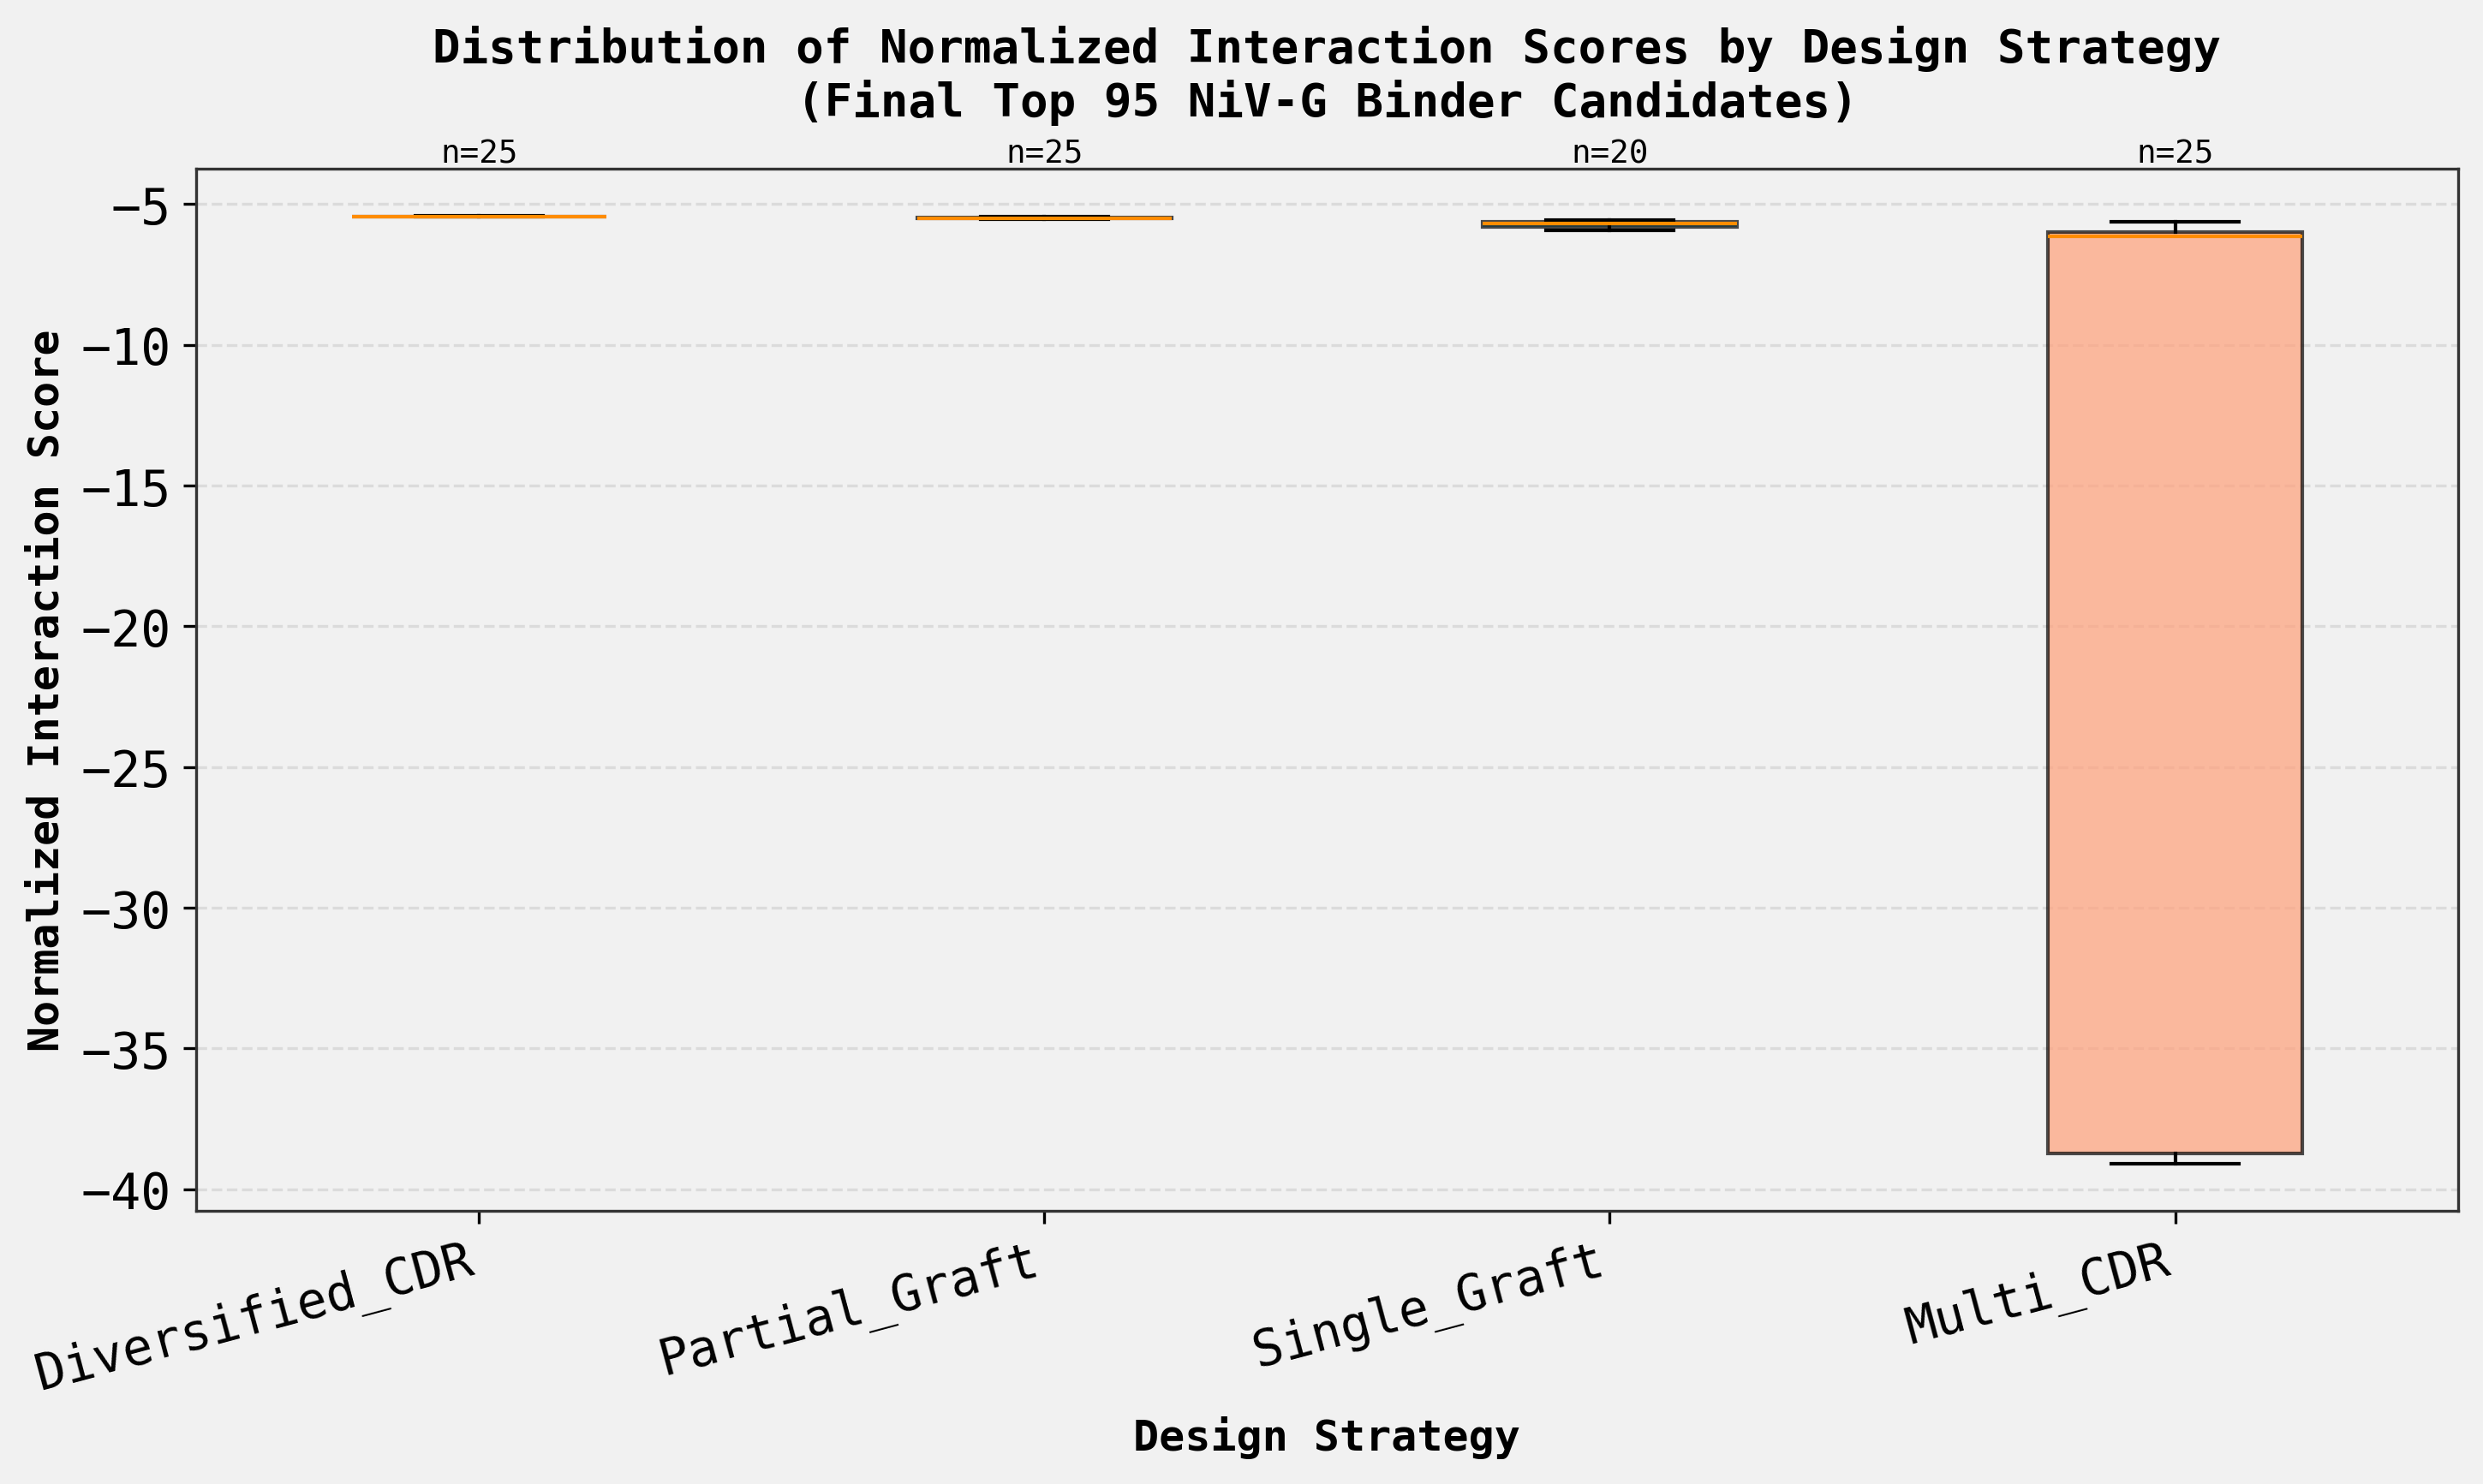


FINAL SUMMARY: TOP 95 NOVEL NIV-G BINDER CANDIDATES

Total candidates: 95

Strategy breakdown:
  Diversified_CDR: 25 designs (26.3%)
  Partial_Graft: 25 designs (26.3%)
  Single_Graft: 20 designs (21.1%)
  Multi_CDR: 25 designs (26.3%)

Target epitope breakdown:
  competitive: 88 designs (92.6%)
  allosteric: 7 designs (7.4%)

Score statistics (Normalized Interaction Score):
  Best (least negative): -5.423
  Worst (most negative): -39.083
  Mean: -8.079
  Median: -5.520



In [ ]:

# Create a final visualization summarizing the results
# Show the distribution of scores and strategies in the final top 95 designs

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# Create a boxplot showing score distributions by strategy
strategies = final_output['Design_Strategy'].unique()
data_by_strategy = [final_output[final_output['Design_Strategy'] == s]['Normalized_Interaction_Score'].values 
                    for s in strategies]

bp = ax.boxplot(data_by_strategy, labels=strategies, patch_artist=True)

# Color the boxes
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Normalized Interaction Score', fontsize=12, fontweight='bold')
ax.set_xlabel('Design Strategy', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Normalized Interaction Scores by Design Strategy\n(Final Top 95 NiV-G Binder Candidates)', 
             fontsize=13, fontweight='bold', pad=15)

# Add grid for readability
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=15, ha='right')

# Add sample size annotations
for i, strategy in enumerate(strategies, 1):
    count = len(final_output[final_output['Design_Strategy'] == strategy])
    ax.text(i, ax.get_ylim()[1], f'n={count}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('final_stratified_top_95_summary.png', dpi=300, bbox_inches='tight')
print("Visualization saved as 'final_stratified_top_95_summary.png'")
plt.show()

# Print final summary statistics
print("\n" + "="*70)
print("FINAL SUMMARY: TOP 95 NOVEL NIV-G BINDER CANDIDATES")
print("="*70)
print(f"\nTotal candidates: {len(final_output)}")
print(f"\nStrategy breakdown:")
for strategy in strategies:
    count = len(final_output[final_output['Design_Strategy'] == strategy])
    pct = 100 * count / len(final_output)
    print(f"  {strategy}: {count} designs ({pct:.1f}%)")

print(f"\nTarget epitope breakdown:")
for epitope in final_output['Target_Epitope'].unique():
    count = len(final_output[final_output['Target_Epitope'] == epitope])
    pct = 100 * count / len(final_output)
    print(f"  {epitope}: {count} designs ({pct:.1f}%)")

print(f"\nScore statistics (Normalized Interaction Score):")
print(f"  Best (least negative): {final_output['Normalized_Interaction_Score'].max():.3f}")
print(f"  Worst (most negative): {final_output['Normalized_Interaction_Score'].min():.3f}")
print(f"  Mean: {final_output['Normalized_Interaction_Score'].mean():.3f}")
print(f"  Median: {final_output['Normalized_Interaction_Score'].median():.3f}")

print("\n" + "="*70)
